<a href="https://colab.research.google.com/github/RA2111003010570/major-proj/blob/main/MAJOR_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout, MaxPooling1D, Reshape, Bidirectional, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/tourism_demand1.csv')

In [7]:
if 'place' in df.columns:
    df.drop(columns=['place'], inplace=True)  # Drop non-numeric columns if present

# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

<ipython-input-7-2a1f9689b1fd>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [9]:
df = df.replace({'#VALUE!': np.nan,  # Replace '#VALUE!' with NaN
                   '': np.nan,           # Add any other strings as needed
                   ' ': np.nan,
                  }, regex=False)

In [11]:
df['month'] = pd.to_datetime(df.iloc[:, 0], format='your_date_format', errors='coerce').dt.month
df['year'] = pd.to_datetime(df.iloc[:, 0], format='your_date_format', errors='coerce').dt.year

In [12]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use past 12 months to predict next month
X, y = create_sequences(data_scaled, seq_length)

In [13]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [57]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Remove last dimension
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Remove last dimension


In [61]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, Bidirectional, BatchNormalization, LeakyReLU

model = Sequential([
    # CNN Block
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(seq_length, X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding='same'),

    # Ensure correct LSTM input shape
    Bidirectional(LSTM(64, return_sequences=True)),
    LSTM(32, return_sequences=False),
    Dropout(0.4),

    # Fully Connected Layers
    Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
    Dense(y.shape[1])  # Output layer
])


In [62]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.3507 - val_loss: 0.3261
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3247 - val_loss: 0.3086
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3122 - val_loss: 0.2940
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2915 - val_loss: 0.2801
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2760 - val_loss: 0.2670
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2624 - val_loss: 0.2548
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2520 - val_loss: 0.2434
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2376 - val_loss: 0.2324
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2266 - val_loss: 0.2210
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2132 - val_loss: 0.2099
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2041 - val_loss: 0.2003
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1941 - val_l

In [64]:
# Assuming 'df' is your DataFrame and 'numerical_cols' are the columns you want to predict
# ... (your previous code) ...

# Initialize the scaler
scaler = MinMaxScaler()

# Check if the target columns are present in the DataFrame
target_cols = ['Domestic-2019-20', 'Foreign-2019-20', 'Revenue-2019-20', 'AvgRevenue-2019-20']  # Replace with your actual target columns if different

# Filter out non-existent columns from target_cols
existing_target_cols = [col for col in target_cols if col in df.columns]

if existing_target_cols:  # Proceed only if there are existing target columns
    # Fit the scaler on the training data only for the existing target columns
    scaler.fit(df.loc[:train_size, existing_target_cols]) # Fit on training data for target columns

    # Transform both training and testing targets
    df.loc[:, existing_target_cols] = scaler.transform(df.loc[:, existing_target_cols])
else:
    print("Error: No target columns found in DataFrame. Scaling skipped.")

# ... (the rest of your code, including create_sequences and model training) ...

# After making predictions
# (Ensure y_pred and y_test have the same number of columns as existing_target_cols)
if existing_target_cols:
    y_pred = model.predict(X_test)

    # Reshape to match the number of existing target columns
    y_pred = y_pred.reshape(-1, len(existing_target_cols))
    y_pred = scaler.inverse_transform(y_pred)

    y_test = y_test.reshape(-1, len(existing_target_cols))
    y_test = scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step


In [65]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [66]:
y_pred = y_pred.reshape(y_test.shape)

In [67]:
temp_pred = np.zeros((y_pred.shape[0], data_scaled.shape[1]))  # Match original scaled data shape
temp_test = np.zeros((y_test.shape[0], data_scaled.shape[1]))

In [68]:
temp_pred[:, -y_pred.shape[1]:] = y_pred
temp_test[:, -y_test.shape[1]:] = y_test


In [69]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [70]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.01
MSE: 0.00
RMSE: 0.06
R² Score: -0.05


In [52]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: inf%


<ipython-input-52-a486dfcd9d68>:1: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [53]:
baseline_pred = np.mean(y_train, axis=0)
baseline_mse = mean_squared_error(y_test, np.tile(baseline_pred, (y_test.shape[0], 1)))
print(f"Baseline MSE: {baseline_mse:.2f}")


Baseline MSE: 0.00


In [75]:
# Ensure y_pred has the correct shape
y_pred = model.predict(X_test)

# Reshape y_pred to match y_test
y_pred = y_pred.reshape(y_test.shape)

# Create a temporary array with the same number of columns as the scaler was fitted on
# This should match the number of target columns (existing_target_cols)
temp_pred = np.zeros((len(y_pred), len(existing_target_cols)))
temp_test = np.zeros((len(y_test), len(existing_target_cols)))

# Assign predictions to the temporary array
temp_pred = y_pred
temp_test = y_test

# Apply inverse transformation
temp_pred = scaler.inverse_transform(temp_pred)  # Now shapes should match
temp_test = scaler.inverse_transform(temp_test)

# Assign the inverse-transformed values back to y_pred and y_test
y_pred = temp_pred
y_test = temp_test

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.01
MSE: 0.00
RMSE: 0.06


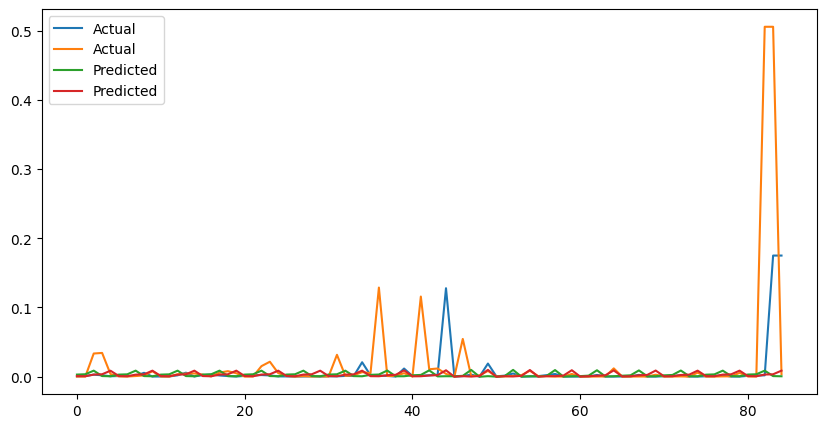

In [74]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")



RMSE: 0.06


In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Reshape X_train and X_test to 2D for RandomForestRegressor
X_train_rf = X_train.reshape(X_train.shape[0], -1)  # Flatten time steps and features
X_test_rf = X_test.reshape(X_test.shape[0], -1)    # Flatten time steps and features

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on training data
rf_model.fit(X_train_rf, y_train)  # Use reshaped X_train

# Make predictions
y_pred_rf = rf_model.predict(X_test_rf)  # Use reshaped X_test

# Reshape predictions to match actual labels
y_pred_rf = y_pred_rf.reshape(y_test.shape)

# Calculate MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Calculate R² Score
r2_rf = r2_score(y_test, y_pred_rf)

# Print Results
print(f"🌲 Random Forest MAE: {mae_rf:.4f}")
print(f"🌲 Random Forest RMSE: {rmse_rf:.4f}")
print(f"🌲 Random Forest R² Score: {r2_rf:.4f}")

🌲 Random Forest MAE: 0.0153
🌲 Random Forest RMSE: 0.0322
🌲 Random Forest R² Score: -5.6683


In [94]:
!pip install xgboost
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variables
# Reshape X to 2D before splitting
X_2D = X.reshape(X.shape[0], -1)  # Reshape to (samples, timesteps * features)
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, test_size=0.2, random_state=42)

# Define XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions (reshape X_test to 2D as well)
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")

XGBoost MAE: 0.01
XGBoost RMSE: 0.03


In [88]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions using the trained CNN model
# Reshape X_test to have the expected 3D shape
# Reshape X_test to match the expected input shape for the CNN
# Get the original shape of X before flattening
original_shape = X.shape

# Reshape X_test based on the original shape
X_test = X_test.reshape((X_test.shape[0], original_shape[1], original_shape[2]))

# Make predictions using the trained CNN model
y_pred_cnn = model.predict(X_test)

# ... (rest of your code)

# Calculate RMSE
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

# Calculate R² Score
r2_cnn = r2_score(y_test, y_pred_cnn)

# Print Results
print(f"✅ CNN RMSE: {rmse_cnn:.4f}")
print(f"✅ CNN R² Score: {r2_cnn:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ CNN RMSE: 0.0232
✅ CNN R² Score: -0.1735


In [90]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the trained LSTM model
y_pred_lstm = model.predict(X_test)

# Reshape predictions to match the actual test labels
y_pred_lstm = y_pred_lstm.reshape(y_test.shape)

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

# Calculate R² Score
r2_lstm = r2_score(y_test, y_pred_lstm)

# Print Results
print(f"✅ LSTM MAE: {mae_lstm:.4f}")
print(f"✅ LSTM RMSE: {rmse_lstm:.4f}")
print(f"✅ LSTM R² Score: {r2_lstm:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✅ LSTM MAE: 0.0075
✅ LSTM RMSE: 0.0232
✅ LSTM R² Score: -0.1735


In [101]:
Dense(5)  # Instead of Dense(1)


<Dense name=dense_28, built=False>

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Splitting Data (Assuming X, y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for CNN (Ensure 3D input shape: (samples, timesteps, features))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# CNN Model (Modified for 5 Outputs)
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure output matches y_train.shape[1] (5 outputs)
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predictions
y_pred_cnn = cnn_model.predict(X_test)

# Compute MAE & RMSE for CNN
cnn_mae = mean_absolute_error(y_test, y_pred_cnn)
cnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

print(f"CNN MAE: {cnn_mae:.2f}")
print(f"CNN RMSE: {cnn_rmse:.2f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0076
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080     
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050     
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052     
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069     
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042     
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063     
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087      
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 
Epoch 16/50
9/9 ━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
CNN MAE: 0.02
CNN RMSE: 0.03


In [103]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Bidirectional
from sklearn.model_selection import train_test_split

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1️⃣ CNN Model ###
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure output shape matches y_train
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_cnn = cnn_model.predict(X_test)

cnn_mae = mean_absolute_error(y_test, y_pred_cnn)
cnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))


### 2️⃣ LSTM Model ###
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)

lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))


### 3️⃣ Random Forest ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape for 2D input
y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))


### 4️⃣ XGBoost ###
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape for 2D input
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))


### 📊 Create a Table for Comparison ###
results_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Random Forest', 'XGBoost'],
    'MAE': [cnn_mae, lstm_mae, rf_mae, xgb_mae],
    'RMSE': [cnn_rmse, lstm_rmse, rf_rmse, xgb_rmse]
})

print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
           Model       MAE      RMSE
0            CNN  0.021603  0.035618
1           LSTM  0.015245  0.023150
2  Random Forest  0.015310  0.032180
3        XGBoost  0.014469  0.037010


In [104]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout

# Assume X and y are already preprocessed feature and target datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hybrid CNN-LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure correct output shape
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Predictions
y_pred_hybrid = model.predict(X_test)

# Compute MAE & RMSE
hybrid_mae = mean_absolute_error(y_test, y_pred_hybrid)
hybrid_rmse = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))

# Display Results
print(f"Hybrid CNN-LSTM MAE: {hybrid_mae:.4f}")
print(f"Hybrid CNN-LSTM RMSE: {hybrid_rmse:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
Hybrid CNN-LSTM MAE: 0.0144
Hybrid CNN-LSTM RMSE: 0.0234
